# Gaussian Mixture Model examples

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import os,sys,time

sys.path.insert(1, '../../src/')
import madmix
import madmix_aux
import gibbs
from concrete import *
import dequantization
import meanfield
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='fig/'
fig_path='../../../madmix-tex/fig/'

In [40]:
def confusion_matrix(true,pred,K):
    """
    Create a confusion matrix when predicting N labels
    that can take K different values
    
    Inputs:
        true : (N,) array, true labels 
        pred : (N,) array, predicted labels
        K    : int, number of classes
    
    Outputs:
        mat : (K,K) array, confusion matrix
    """
    mat=np.zeros((K,K))
    for k1 in range(K):
        for k2 in range(K):
            mat[k1,k2]=np.logical_and(true==k1, pred==k2).sum()
        # end for
    # end for
    return mat

def permute_labels(pred,dim1,dim2,K):
    """
    Permute the dim1 and dim2 labels of pred
    
    Inputs:
        pred : (N,) array, predicted labels
        dim1 : int, first label to swap
        dim2 : int, second label to swap
        K    : int, number of classes
    
    Outputs:
        perm : (N,) array, permuted labels
    """
    perm=np.copy(pred)
    perm[perm==dim1]=K+1
    perm[perm==dim2]=dim1
    perm[perm==(K+1)]=dim2
    return perm


def gmm_lposterior(xd,w,mus,Sigmas,y,mu0,Sigma0):
    """
    Evaluate the log posterior density of a GMM (given data y)
    
    Inputs:
        xd     : (N,B) array, labels (N = # of observations, B = Monte Carlo sample size)
        w      : (K,B) array, weights (K = # of clusters)
        mus    : (K,D,B) array, cluster means (D = dimension of observations)
        Sigmas : (K,D,D,B) array, cluster covariances
        y      : (N,D) array, observations
        mu0    : (K,D,B) array, prior cluster means 
        Sigma0 : (K,D,D,B) array, prior cluster covariances
    
    Outputs:
        lp     : (B,) array, posterior distribution log density up to normalizing constant
    """
    N=xd.shape[0]
    K,D,B=mus.shape
    chol=np.linalg.cholesky(np.moveaxis(Sigmas,3,1)) # (K,B,D,D)
    
    #lp = stats.dirichlet(np.ones(K)).logpdf(w) # prior weights
    lp = 0.6931471805599453*np.ones(B) # uninformative dirichlet value; prevents issues when sum(w)<1 but very close
    for k in range(K):
        std_mu = np.squeeze(np.matmul(chol[k,:,:,:],(mus[k,:,:]-mu0[k,:,None]).T[:,:,None]))
        lp += stats.invwishart(df=N/K,scale=Sigma0[k,:,:]*N/K).logpdf(Sigmas[k,:,:,:]) # prior Sigma
        lp += stats.multivariate_normal(mean=np.zeros(D),cov=np.eye(D)).logpdf(std_mu) # prior mu
    # end for
    
    for n in range(N): lp += np.log(w[xd[n,:].astype(int),np.arange(B)]) # prior labels
    
    for n in range(N):
        for k in range(K):
            std_y = np.squeeze(np.matmul(chol[k,:,:,:],(y[n,:,None]-mus[k,:,:]).T[:,:,None]))
            tmplp = stats.multivariate_normal(mean=np.zeros(D),cov=np.eye(D)).logpdf(std_y) # likelihood
            tmplp += np.log(w[k]) # likelihood
            
            idx = (xd[n,:]==k) # label n = cluster k
            ll  = np.zeros(B)
            ll[idx]=tmplp[idx]  # when xn=k, add gaussian lp
            lp += ll
        # end for
    # end for
    
    return lp

## Palmer penguin data set

In [3]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
K=3

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_44926/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_44926/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data


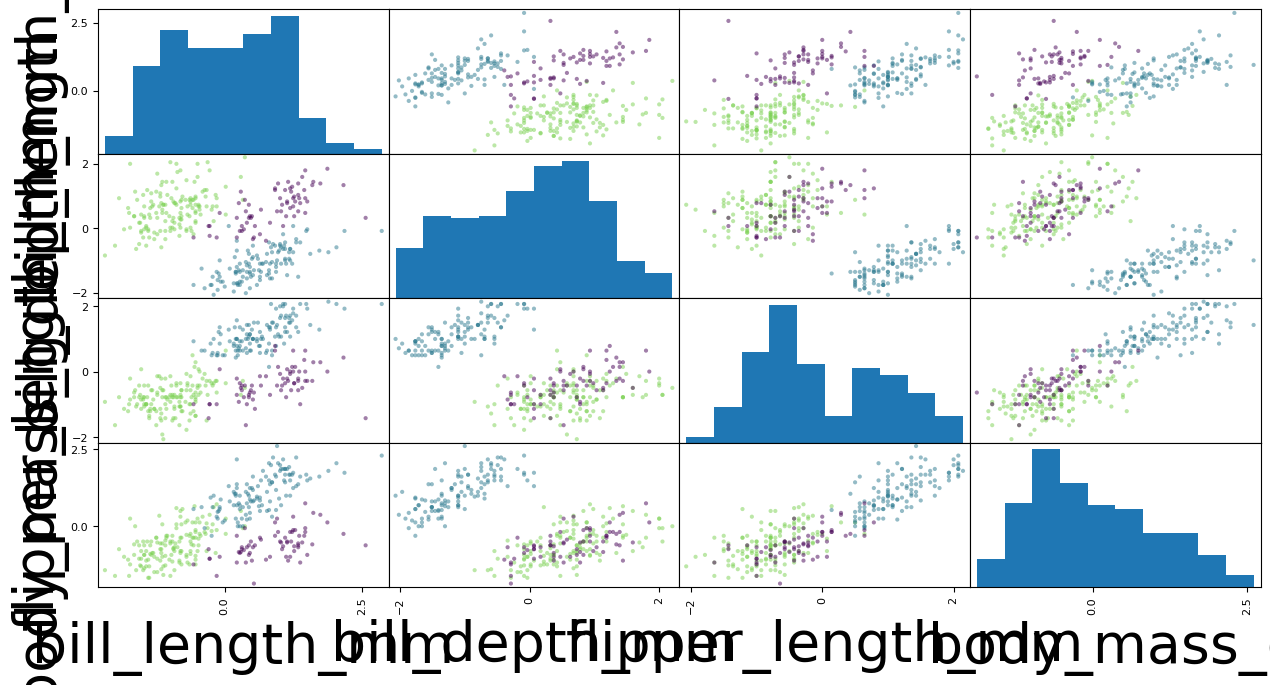

In [4]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [5]:
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])
pg_true=np.squeeze(np.array(penguins[['species']]))
pg_true[pg_true=='Adelie']=0
pg_true[pg_true=='Gentoo']=1
pg_true[pg_true=='Chinstrap']=2

In [12]:
N,D=pg_dat.shape
K=3

### Gibbs sampling

In [188]:
####################
####################
#      setup       #
####################
####################
gibbs_cput  =  np.inf*np.ones(2)

# settings
steps=1000
burnin_pct=0.9
D=pg_dat.shape[1]

# initial arrays
#mu0=np.array([[35.,25.,175.,3500.],  # green
#              [55.,17.,200.,4000.],  # purple 
#              [45.,10.,225.,5000.]]) # blue
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=0.5*np.eye(D)
w0=np.ones(K)/K

In [189]:
####################
####################
#   run sampler    #
####################
####################
seed=1

t0=time.perf_counter()
xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=pg_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)
gibbs_cput[0]=time.perf_counter()-t0

In [190]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(xs,'sockeye_run/penguin/pred_x')
aux.pkl_save(ws,'sockeye_run/penguin/pred_w')
aux.pkl_save(mus,'sockeye_run/penguin/pred_mu')
aux.pkl_save(sigmas,'sockeye_run/penguin/pred_sigma')

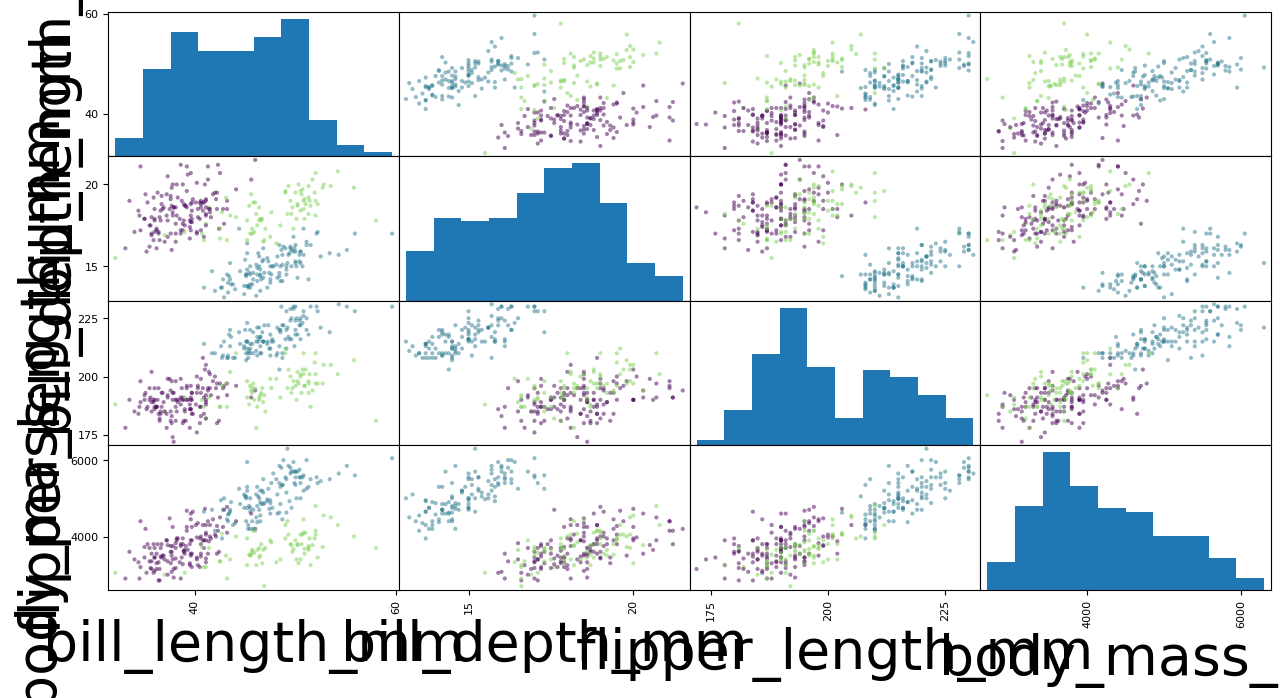

In [191]:
colors[xs[-1,:]==0]='#440154'
colors[xs[-1,:]==1]='#7ad151'
colors[xs[-1,:]==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [192]:
pred_x=xs.T
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
gibbs_pred_pg=np.argmax(x_prbs,axis=1)

# account for label permutation
gibbs_pred_pg=permute_labels(gibbs_pred_pg,1,2,K)

In [193]:
confusion_matrix(pg_true,gibbs_pred_pg,K)

array([[144.,   0.,   2.],
       [  0., 119.,   0.],
       [  3.,   0.,  65.]])

### MAD Mix

In [20]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=10
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=0.5*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/0.5
# end for
w0=np.ones(K)/K
nu0=1.

randq0=madmix_aux.gen_randq0(N,mu0,sigma0,invsigma0)
lq0=madmix_aux.gen_lq0(N,mu0,sigma0)
lp = madmix_aux.gmm_gen_lp(K,np.array(pg_dat))
gen_grad_lp=madmix_aux.gmm_gen_grad_lp(K,np.array(pg_dat))

In [195]:
RUN=True # to control whether to run or to import saved results
madmix_elbos = -np.inf*np.ones(2)

if RUN:
    madmix_cput  =  np.inf*np.ones(2)
    
    print('Sampling')
    t0=time.perf_counter()
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)
    madmix_cput[0]=time.perf_counter()-t0
    
    mad_pg_results=madmix_aux.madmix_gmm_pack(xd_,ud_,xc_,rho_,uc_)
    print('Done!')
    print('Saving sampling results')
    aux.pkl_save(mad_pg_results,'results/mad_pg_results')
    
    print('Evaluating log density')
    mad_lq_pg = madmix.lqN(xd_.astype(int),ud_,xc_,rho_,uc_,N,lq0,L,epsilon,lp,gen_grad_lp,xi)
    print('Done!')
    print('Saving log density results')
    aux.pkl_save(mad_lq_pg,'results/mad_pg_lq')
else:
    mad_pg_results=aux.pkl_load('results/mad_pg_results')
    mad_lq_pg=aux.pkl_load('results/mad_pg_lq')
    xd_,ud_,xc_,rho_,uc_=madmix_aux.madmix_gmm_unpack(mad_pg_results,N,K,D)
# end if

Sampling
Done!ing 100/100
Saving sampling results
Evaluating log density


/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/ham_mixflows.py:231: RuntimeWarning: divide by zero encountered in log1p
  def lap_Qm(p)  :     return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5))          #(M,d)->(M,d)
/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/madmix.py:56: RuntimeWarning: invalid value encountered in add
  w[n+1,:]=lq0(xd_,ud_,xc_,rho_,uc_)+tlJ # update weight


Done!
Saving log density results


In [196]:
ws_,mus_,Hs_=madmix_aux.madmix_gmm_unflatten(xc_,K,D)
ws_=ws_/np.sum(ws_,axis=0)[None,:]
Sigmas_=madmix_aux.HtoSigma(Hs_)

pred_x=np.copy(xd_)
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
mad_pred_pg=np.argmax(x_prbs,axis=1)

In [197]:
# elbo computation
idx=np.logical_not(np.isnan(mad_lq_pg))
llp=gmm_lposterior(xd_[...,idx],ws_[...,idx],mus_[...,idx],Sigmas_[...,idx],pg_dat,mu0,sigma0)
madmix_elbos[0]=-np.mean(mad_lq_pg[idx]-llp)

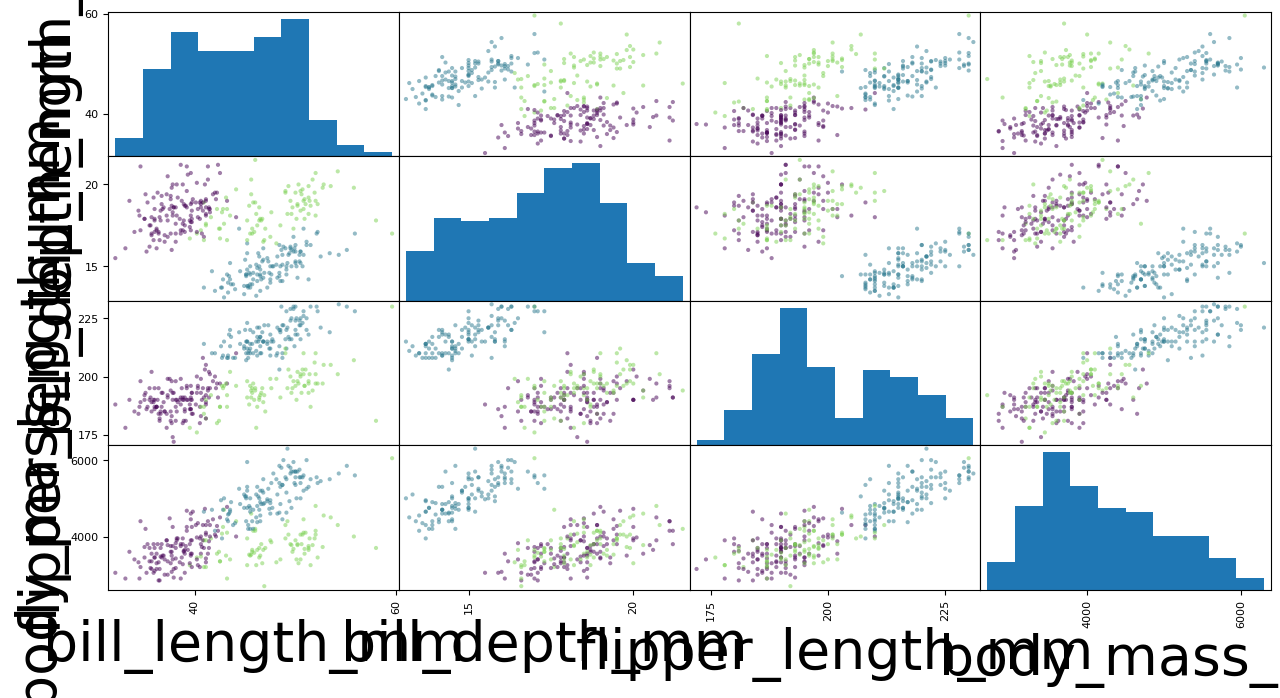

In [198]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[mad_pred_pg==0]='#440154'
colors[mad_pred_pg==1]='#7ad151'
colors[mad_pred_pg==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [199]:
# account for label permutation
mad_pred_pg=permute_labels(mad_pred_pg,1,2,K)

confusion_matrix(pg_true,mad_pred_pg,K)

array([[129.,   0.,  17.],
       [  0., 118.,   1.],
       [  0.,   0.,  68.]])

### Mean field

In [200]:
####################
####################
#      setup       #
####################
####################
meanfield_elbos = -np.inf*np.ones(2)
meanfield_cput  =  np.inf*np.ones(2)

K=3
y=pg_dat
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,4,4))
for k in range(K): sigma0[k,:,:]=1.*np.eye(4)
iterations=10000

In [201]:
####################
####################
#  run optimizer   #
####################
####################
t0=time.perf_counter()
alphas,lrs,ms,betas,invWs,nus=meanfield.meanfieldGMM(y,mu0,sigma0,iterations)
meanfield_cput[0]=time.perf_counter()-t0

In [202]:
# compute ELBO
meanfield_elbos[0]=meanfield.meanfield_gmm_elbo(10000,gmm_lposterior,alphas,lrs,ms,betas,invWs,nus,y,mu0,sigma0)

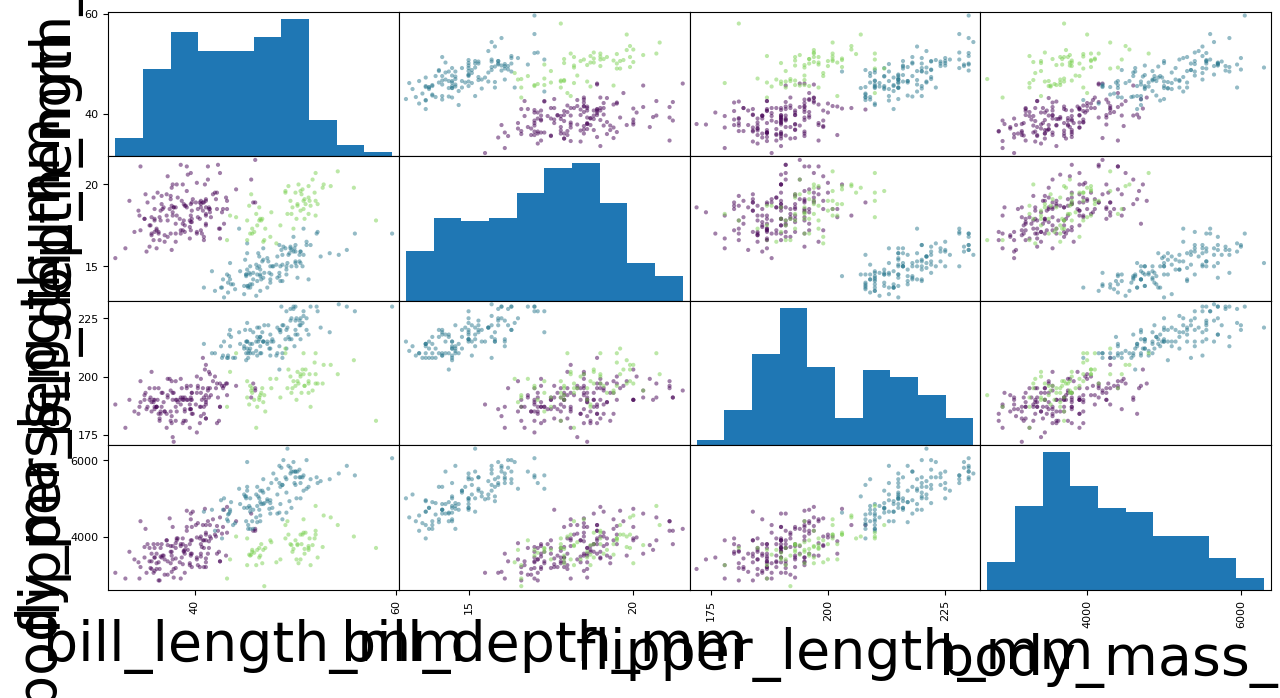

In [203]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[np.argmax(lrs,axis=1)==0]='#440154'
colors[np.argmax(lrs,axis=1)==1]='#7ad151'
colors[np.argmax(lrs,axis=1)==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [204]:
# account for label permutation
mf_pred_pg=np.argmax(lrs,axis=1)
mf_pred_pg=permute_labels(mf_pred_pg,1,2,K)


confusion_matrix(pg_true,mf_pred_pg,K)

array([[145.,   0.,   1.],
       [  0., 119.,   0.],
       [  5.,   0.,  63.]])

### Dequantization

In [ ]:
########################
########################
#    dequantization    #
########################
########################
dequant_flows_pg     = pkl_load('sockeye/dequantization/penguin/flows_dequant')
dequant_losses_pg    = pkl_load('sockeye/dequantization/penguin/losses_dequant')
dequant_cpu_times_pg = pkl_load('sockeye/dequantization/penguin/cpu_times_dequant')
dequant_densitycput  = np.zeros((2,len(dequant_flows_pg)))
dequant_sim_size_pg  = len(dequant_flows_pg)
dequant_max_iters_pg = dequant_losses_pg.shape[-1]
print('Total training time: '+str(dequant_cpu_times_pg.sum()/3600)+' hours')

In [9]:
path='sockeye/dequantization/penguin/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

dequant_losses_pg=np.zeros((len(losses_files),10001))
dequant_flows_pg=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    dequant_losses_pg[i]=aux.pkl_load(path+losses_files[i])
    dequant_flows_pg[i]=aux.pkl_load(path+flows_files[i])
# end for

dequant_densitycput  = np.zeros((2,len(dequant_flows_pg)))
dequant_sim_size_pg  = len(dequant_flows_pg)
dequant_max_iters_pg = dequant_losses_pg.shape[-1]
#print('Total training time: '+str(dequant_cpu_times_pg.sum()/3600)+' hours')

Text(0.5, 1.0, 'Dequantization RealNVP training loss traceplots')

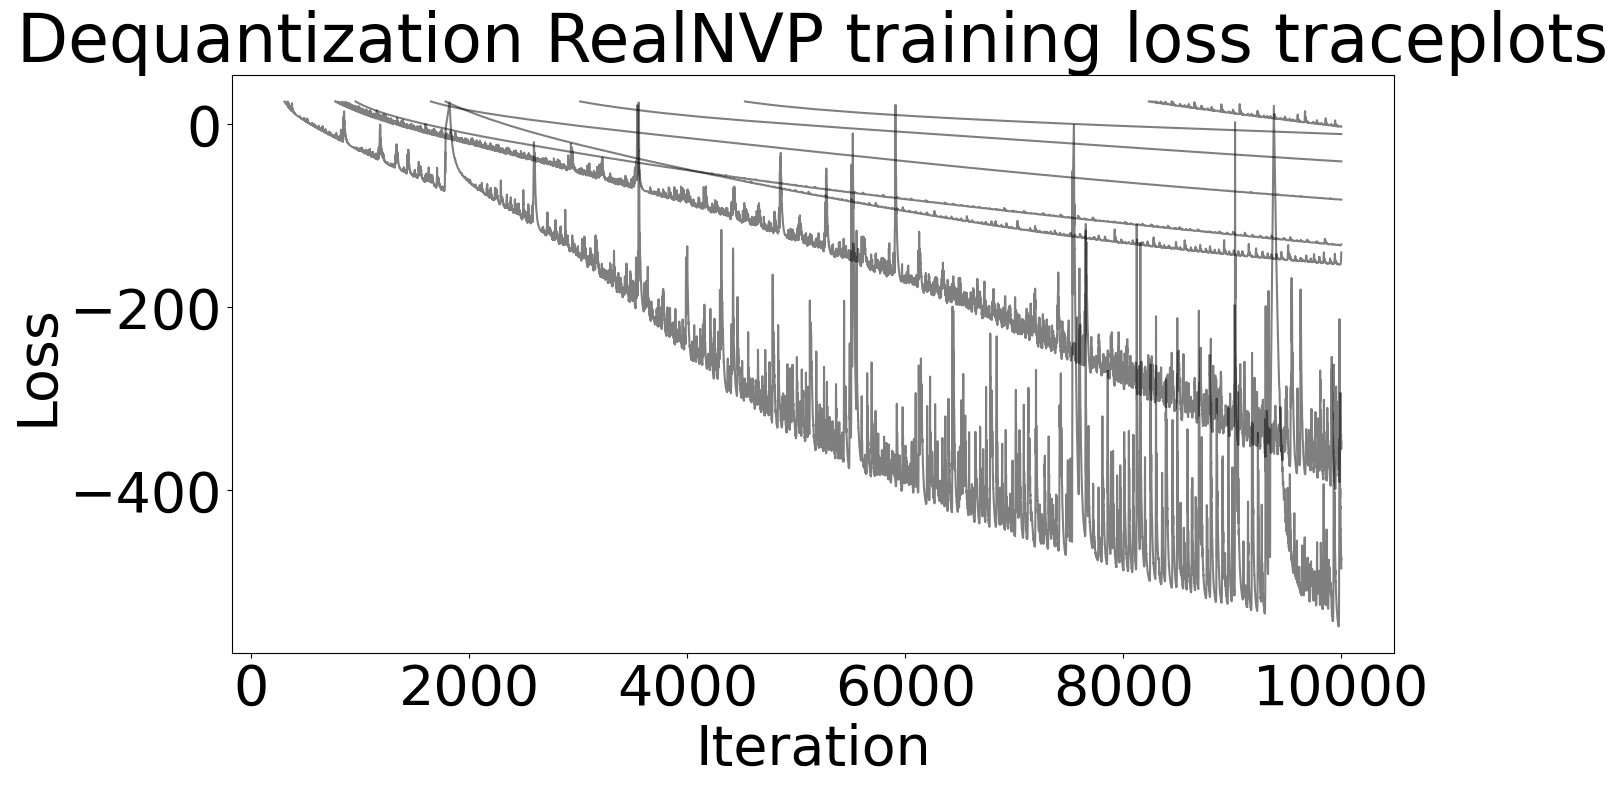

In [10]:
# loss traceplot
threshold=25
for i in range(dequant_sim_size_pg): plt.plot(np.arange(dequant_max_iters_pg)[dequant_losses_pg[i,:]<threshold],dequant_losses_pg[i,dequant_losses_pg[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Dequantization RealNVP training loss traceplots')

In [44]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
Kpp=int(N+K+K*D+K*(D+D*(D-1)/2))
dequant_samples_pg=np.zeros((dequant_sim_size_pg,sample_size,Kpp))
dequant_densities_pg=np.zeros((dequant_sim_size_pg,sample_size))
dequant_elbos_pg=-np.inf*np.ones(dequant_sim_size_pg)

for i in range(dequant_sim_size_pg):
    print(str(i+1)+'/'+str(dequant_sim_size_pg),end='\r')
    tmp_flow=dequant_flows_pg[i]
    if isinstance(tmp_flow, int): continue
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    dequant_samples_pg[i,:,:] = tmp_sample.detach().numpy()
    
    # unpack and quantize sample
    xd_dequant_pg,ws_dequant_pg,mus_dequant_pg,Sigmas_dequant_pg=dequantization.dequant_gmm_unpack(tmp_sample,N,K,D)
    ws_dequant_pg=project_simplex_2d(ws_dequant_pg.T).detach().numpy().T
    mus_dequant_pg=mus_dequant_pg.detach().numpy()
    Sigmas_dequant_pg=Sigmas_dequant_pg.detach().numpy()
    xd_dequant_pg=np.floor(xd_dequant_pg).astype(int) # quantize
    xd_dequant_pg[xd_dequant_pg<0]=0
    xd_dequant_pg[xd_dequant_pg>K-1]=K-1
    
    # compute density
    t0=time.perf_counter()
    dequant_densities_pg[i,:]=tmp_flow.log_prob(tmp_sample).detach().numpy()
    dequant_densitycput[0,i]=time.perf_counter()-t0
    
    # estimate elbo
    llp = gmm_lposterior(xd_dequant_pg,ws_dequant_pg,mus_dequant_pg,Sigmas_dequant_pg,pg_dat,mu0,sigma0)
    dequant_elbos_pg[i]=-np.mean(dequant_densities_pg[i,:] - llp)
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_44926/407853305.py:70: RuntimeWarning: divide by zero encountered in log
  for n in range(N): lp += np.log(w[xd[n,:].astype(int),np.arange(B)]) # prior labels
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_44926/407853305.py:76: RuntimeWarning: divide by zero encountered in log
  tmplp += np.log(w[k]) # likelihood


<Figure size 1500x750 with 0 Axes>

### Concrete 

In [150]:
####################
####################
#    load data     #
####################
####################
path='sockeye/penguin/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

concrete_pg_losses=np.zeros((len(losses_files),10001))
concrete_pg_flows=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    concrete_pg_losses[i]=aux.pkl_load(path+losses_files[i])
    concrete_pg_flows[i]=aux.pkl_load(path+flows_files[i])
# end for

# got from cache and output text files
concrete_pg_cput = np.array([6618.314439028036,5059.62303130200,4895.326881411951,4699.00335305091,9839.828872337937])

Text(0, 0.5, 'Loss')

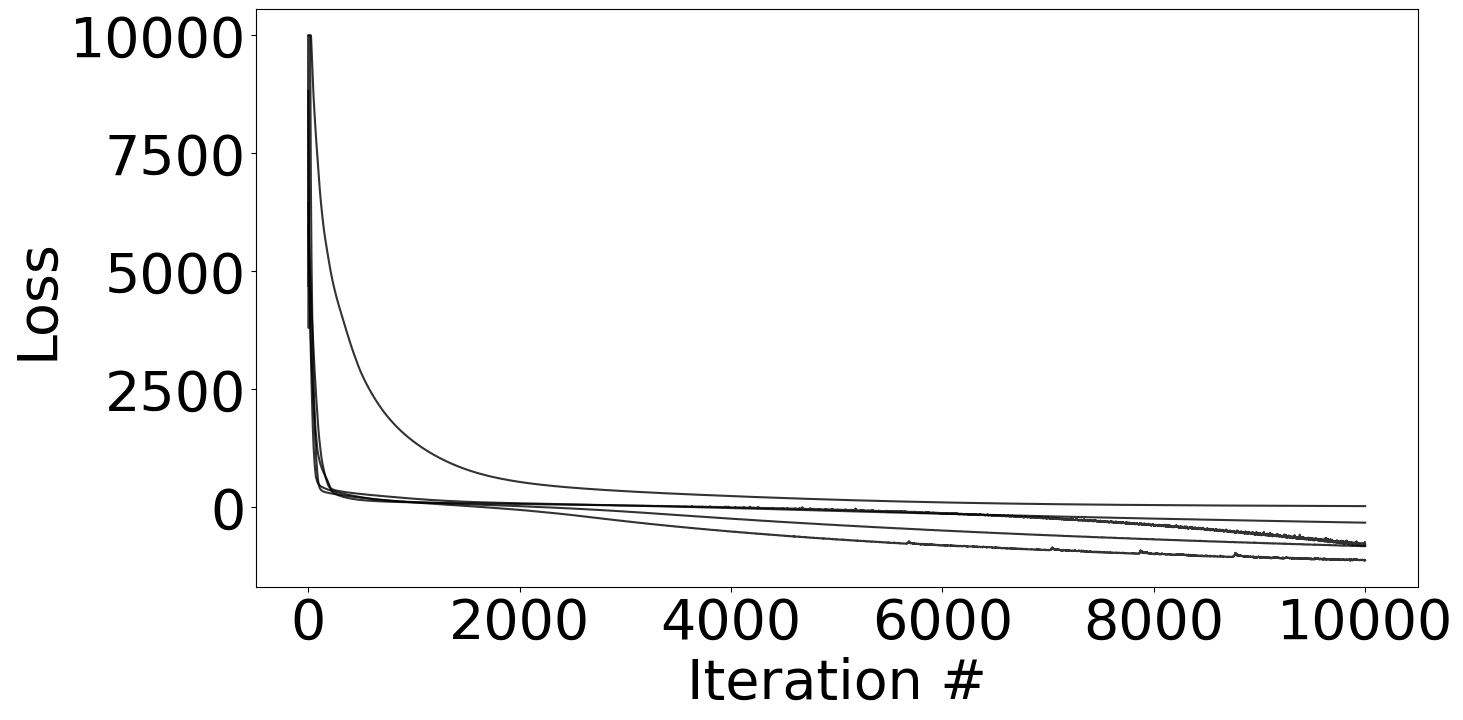

In [151]:
# loss traceplot
threshold=10000
plt_losses=np.copy(concrete_pg_losses)
plt_losses[plt_losses>threshold]=threshold
for i in range(len(losses_files)): plt.plot(np.arange(10001),plt_losses[i,:],c='black',alpha=0.8)
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [152]:
torch.manual_seed(1)
N,K,D=xs.shape[1],mus.shape[1],mus.shape[2]
idx=np.diag_indices(D)
for i in [np.argmin(concrete_pg_losses[:,-1])]:#range(len(flows_files)):
    tmp_sample=concrete_pg_flows[i].sample(1000)
    xd_pg,ws_pg,mus_pg,Sigmas_pg=concrete_gmm_unpack(tmp_sample,N,K,D)
    ws_pg,mus_pg,Sigmas_pg=ws_pg.detach().numpy(),mus_pg.detach().numpy(),Sigmas_pg.detach().numpy()
    Sigmas_pg[:,idx[0],idx[1],:]+=1e-1
    ws_pg=np.exp(ws_pg)/np.sum(np.exp(ws_pg),axis=0)[None,:]

/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:253: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_34091/2089116592.py:9: RuntimeWarning: overflow encountered in exp
  ws_pg=np.exp(ws_pg)/np.sum(np.exp(ws_pg),axis=0)[None,:]
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_34091/2089116592.py:9: RuntimeWarning: invalid value encountered in divide
  ws_pg=np.exp(ws_pg)/np.sum(np.exp(ws_pg),axis=0)[None,:]


In [153]:
gmm_lposterior(np.argmax(xd_pg,axis=1),ws_pg,mus_pg,Sigmas_pg,pg_dat,mu0,sigma0)

LinAlgError: Matrix is not positive definite

In [123]:
# retrieve best flow
i_star=np.argmin(concrete_pg_losses[:,-1])
best_flow=concrete_pg_flows[i_star]
print('Optimal flow: '+str(i_star))

Optimal flow: 0


In [127]:
flow_sample.shape

torch.Size([10000, 1044])

In [124]:
# generate sample from optimal flow
#torch.manual_seed(1)
flow_sample=best_flow.sample(10000)

/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:253: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [86]:
# loss 124 is smallest
# corresponds to: temp: 5, depth: 64, width: 100, lr: 1e-5
# here we train it manually
N,K,D=xs.shape[1],mus.shape[1],mus.shape[2]
tau0=0.1

temp = 5.
depth = 64
width = 100

lr = 1e-5
max_iters=10001

In [14]:
# sample generation
xs_concrete=torch.from_numpy(xs)
ws_concrete=torch.from_numpy(ws)
mus_concrete=torch.from_numpy(mus)
sigmas_concrete=torch.from_numpy(sigmas)

conc_sample=gmm_concrete_sample(xs_concrete,ws_concrete,mus_concrete,sigmas_concrete,temp)

In [15]:
RUN=False
if RUN:
    tmp_flow_penguin,tmp_loss_penguin=trainGMMRealNVP(
        temp=temp,depth=depth,N=N,K=K,D=D,tau0=tau0,sample=conc_sample,width=width,max_iters=max_iters,lr=lr,seed=2023,verbose=True
    )
# end if

iter 0: loss = 8825.073
iter 1000: loss = 96.729
iter 2000: loss = -65.055
iter 3000: loss = -304.835
iter 4000: loss = -526.478
iter 5000: loss = -692.925
iter 6000: loss = -815.025
iter 7000: loss = -924.330
iter 8000: loss = -1009.998
iter 9000: loss = -1075.286
iter 10000: loss = -1137.199


Text(0, 0.5, 'Loss')

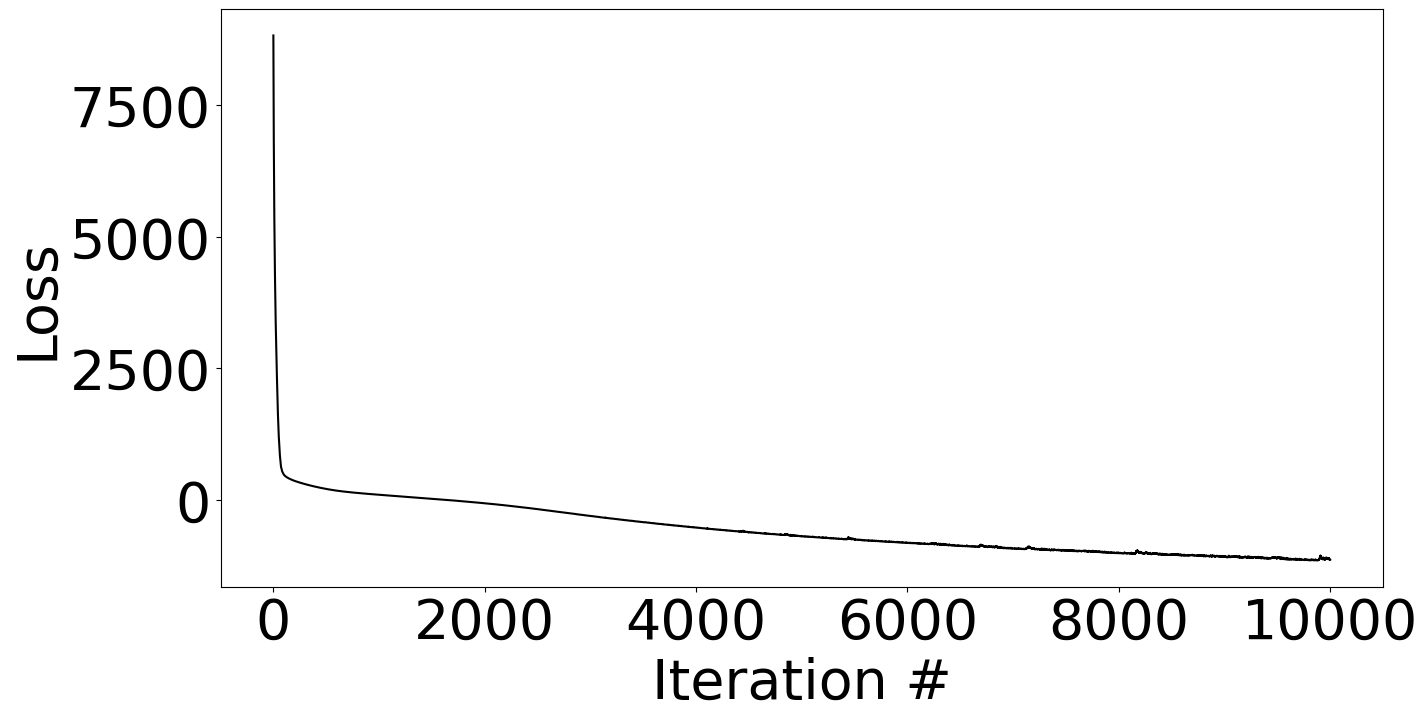

In [34]:
plt.plot(np.arange(10001),tmp_loss_penguin,c='black')
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [84]:
# generate sample from optimal flow
torch.manual_seed(1)
flow_sample=tmp_flow_penguin.sample(10000)

In [118]:
xd_pg,ws_pg,mus_pg,Sigmas_pg=concrete_gmm_unpack(flow_sample,pg_dat.shape[0],K,D)
ws_pg,mus_pg,Sigmas_pg=ws_pg.detach().numpy(),mus_pg.detach().numpy(),Sigmas_pg.detach().numpy()

In [139]:
pg_cols_one=np.mean(np.argmax(xd_pg,axis=1),axis=-1)

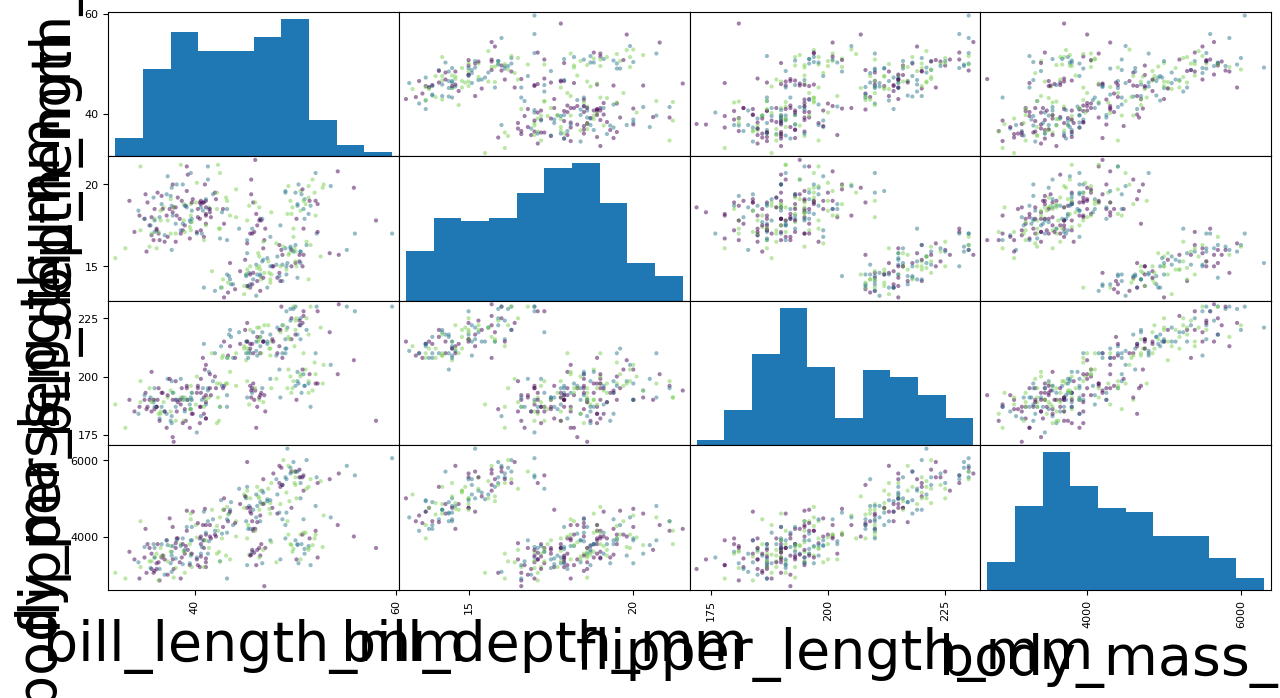

In [140]:
colors[pg_cols_one==0]='#440154'
colors[pg_cols_one==1]='#7ad151'
colors[pg_cols_one==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

## Waveform data set

In [205]:
from sklearn.decomposition import PCA
waveform_dat=pd.read_table('https://hastie.su.domains/ElemStatLearn/datasets/waveform.train')
pca = PCA(n_components=4)
pca.fit(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])
waveform_pca=np.array(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])@pca.components_.T

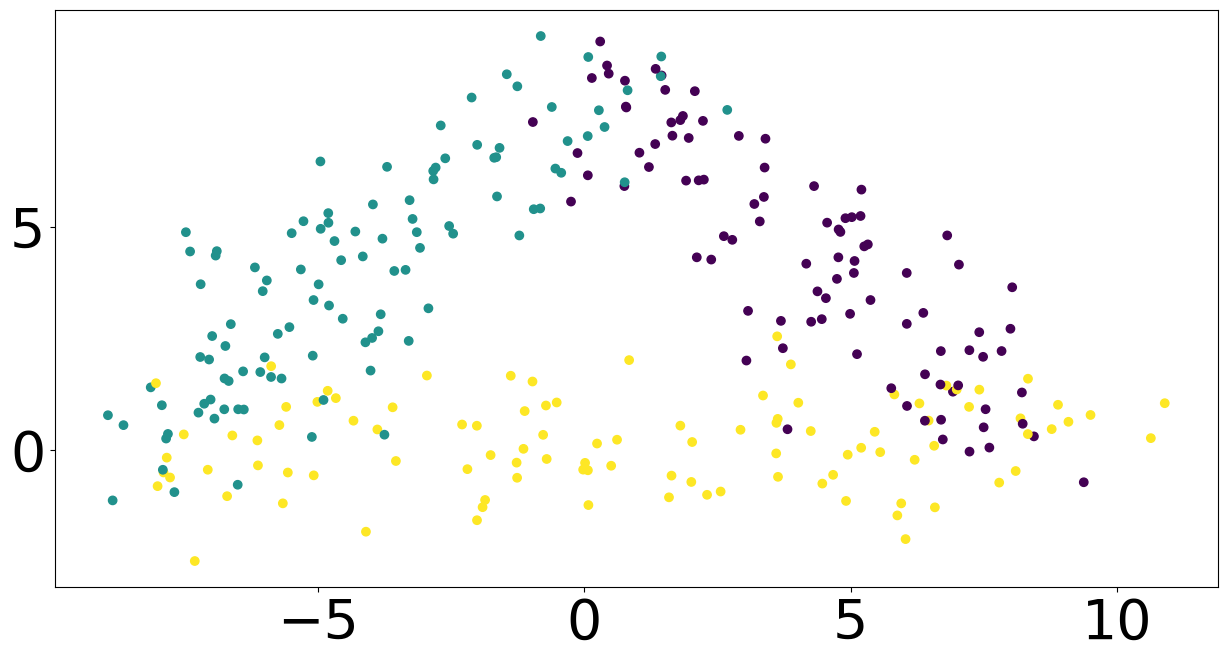

In [206]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.squeeze(np.array(waveform_dat[['y']])))

In [207]:
wf_true=np.squeeze(np.array(waveform_dat[['y']]))-1
wf_dat=waveform_pca[:,:2]
K=3

### Gibbs sampling

In [208]:
####################
####################
#      setup       #
####################
####################

# settings
steps=1000
burnin_pct=0.9
D=wf_dat.shape[1]

# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=5.*np.eye(D)
w0=np.ones(K)/K

In [209]:
####################
####################
#   run sampler    #
####################
####################
seed=1

t0=time.perf_counter()
xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=wf_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)
gibbs_cput[1]=time.perf_counter()-t0

In [210]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(xs,'sockeye_run/waveform/pred_x')
aux.pkl_save(ws,'sockeye_run/waveform/pred_w')
aux.pkl_save(mus,'sockeye_run/waveform/pred_mu')
aux.pkl_save(sigmas,'sockeye_run/waveform/pred_sigma')

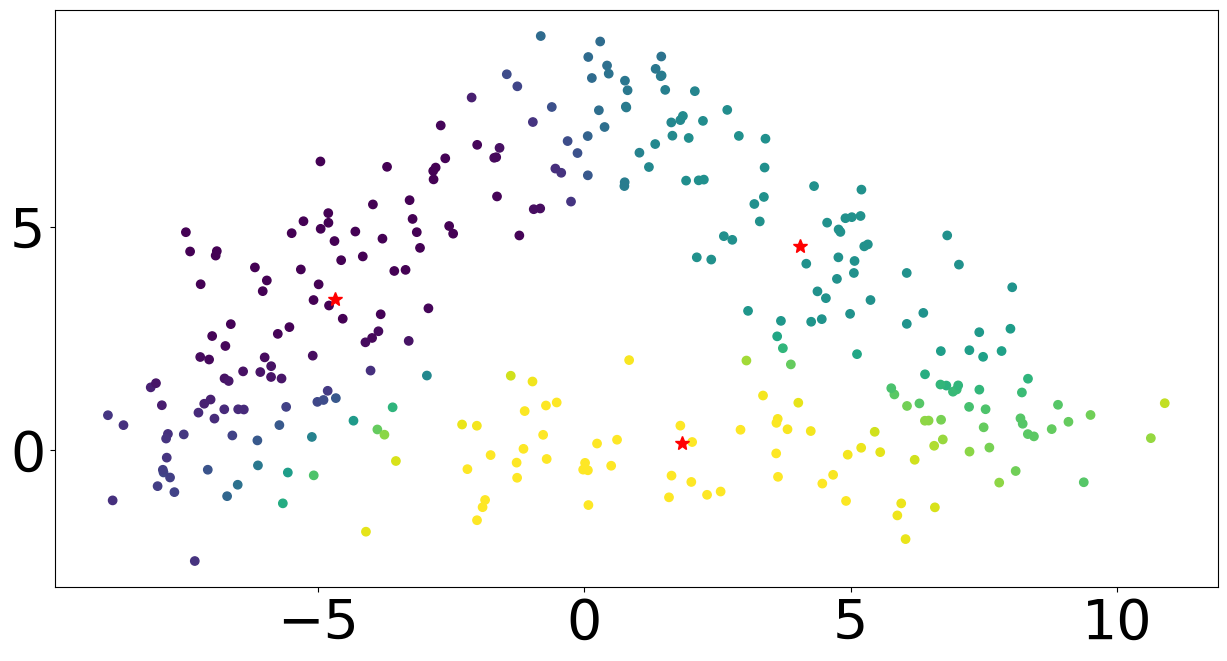

In [211]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.mean(xs,axis=0))
plt.plot(np.mean(mus,axis=0)[:,0],np.mean(mus,axis=0)[:,1],'*r',ms=10)


xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus,axis=0)[k,:], np.mean(sigmas,axis=0)[k,:,:])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [212]:
pred_x=xs.T
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T

In [213]:
# account for label permutation
gibbs_pred_wf=np.argmax(x_prbs,axis=1)
gibbs_pred_wf=permute_labels(gibbs_pred_wf,0,1,K)

confusion_matrix(wf_true,gibbs_pred_wf,K)

array([[82.,  3.,  9.],
       [10., 95.,  1.],
       [11., 19., 70.]])

### MAD Mix

In [214]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=10
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
N,D=wf_dat.shape
K=3
# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=5.*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/5.
w0=np.ones(K)/K
nu0=1.

randq0=madmix_aux.gen_randq0(N,mu0,sigma0,invsigma0)
lq0=madmix_aux.gen_lq0(N,mu0,sigma0)
lp = madmix_aux.gmm_gen_lp(K,np.array(wf_dat))
gen_grad_lp=madmix_aux.gmm_gen_grad_lp(K,np.array(wf_dat))

In [215]:
RUN=True # to control whether to run or to import saved results

if RUN:
    print('Sampling')
    t0=time.perf_counter()
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)
    madmix_cput[1]=time.perf_counter()-t0
    
    mad_wf_results=madmix_aux.madmix_gmm_pack(xd_,ud_,xc_,rho_,uc_) 
    print('Done!')
    print('Saving sampling results')
    aux.pkl_save(mad_wf_results,'results/mad_wf_results')
    
    print('Evaluating log density')
    mad_lq_wf = madmix.lqN(xd_.astype(int),ud_,xc_,rho_,uc_,N,lq0,L,epsilon,lp,gen_grad_lp,xi)
    print('Done!')
    print('Saving log density results')
    aux.pkl_save(mad_lq_wf,'results/mad_wf_lq')
else:
    mad_wf_results=aux.pkl_load('results/mad_wf_results')
    mad_lq_wf=aux.pkl_load('results/mad_wf_lq')
    xd_,ud_,xc_,rho_,uc_=madmix_aux.madmix_gmm_unpack(mad_wf_results,N,K,D)
# end if

Sampling
Done!ing 100/100
Saving sampling results
Evaluating log density


/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/ham_mixflows.py:231: RuntimeWarning: divide by zero encountered in log1p
  def lap_Qm(p)  :     return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5))          #(M,d)->(M,d)
/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/madmix.py:56: RuntimeWarning: invalid value encountered in add
  w[n+1,:]=lq0(xd_,ud_,xc_,rho_,uc_)+tlJ # update weight


Done!
Saving log density results


In [216]:
ws_,mus_,Hs_=madmix_aux.madmix_gmm_unflatten(xc_,K,D)
ws_=ws_/np.sum(ws_,axis=0)[None,:]
Sigmas_=madmix_aux.HtoSigma(Hs_)

pred_x=np.copy(xd_)
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
mad_pred_wf=np.argmax(x_prbs,axis=1)

In [217]:
# elbo computation
idx=np.logical_not(np.isnan(mad_lq_wf))
llp=gmm_lposterior(xd_[...,idx],ws_[...,idx],mus_[...,idx],Sigmas_[...,idx],wf_dat,mu0,sigma0)
madmix_elbos[1]=-np.mean(mad_lq_wf[idx]-llp)

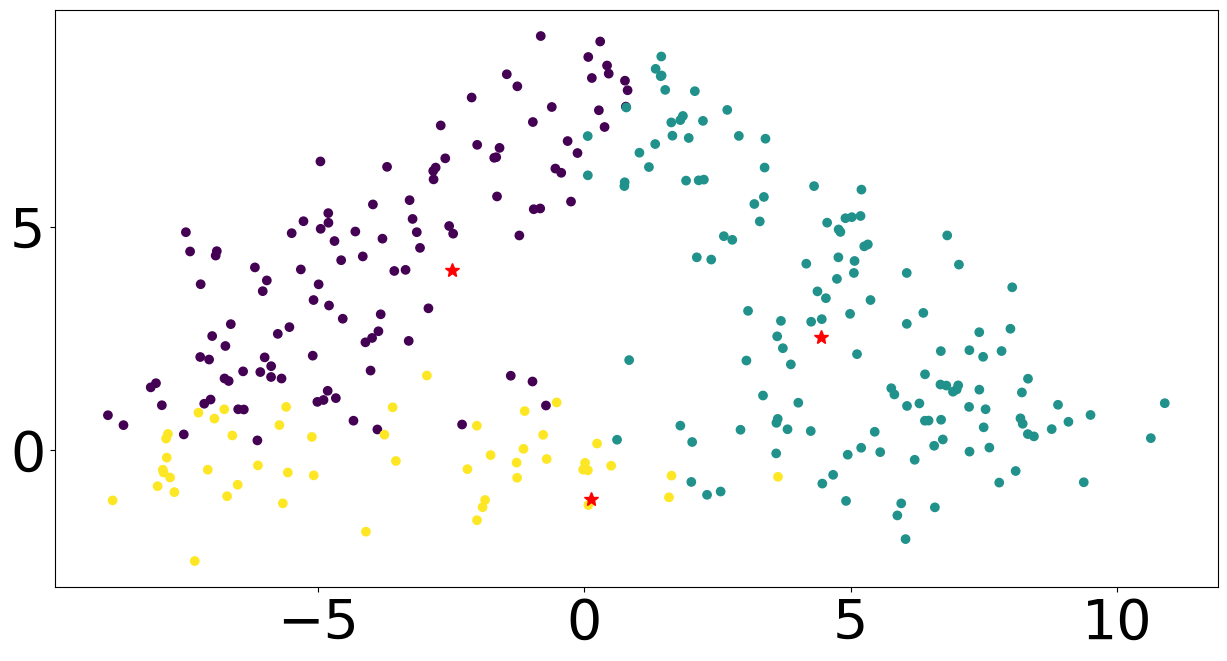

In [218]:
plt.scatter(wf_dat[:,0],wf_dat[:,1],c=mad_pred_wf)
plt.plot(np.mean(mus_,axis=-1)[:,0],np.mean(mus_,axis=-1)[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus_[k,:,:],axis=-1), np.mean(Sigmas_[k,...],axis=-1))
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [219]:
# account for label permutation
mad_pred_wf=permute_labels(mad_pred_wf,0,1,K)

confusion_matrix(wf_true,mad_pred_wf,K)

array([[85.,  9.,  0.],
       [ 5., 90., 11.],
       [47., 13., 40.]])

### Mean field

In [220]:
####################
####################
#      setup       #
####################
####################
K=3
y=wf_dat
# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(2)
iterations=10000

In [221]:
####################
####################
#  run optimizer   #
####################
####################
t0=time.perf_counter()
alphas,lrs,ms,betas,invWs,nus=meanfield.meanfieldGMM(y,mu0,sigma0,iterations)
meanfield_cput[1]=time.perf_counter()-t0

In [222]:
# compute ELBO
meanfield_elbos[1]=meanfield.meanfield_gmm_elbo(10000,gmm_lposterior,alphas,lrs,ms,betas,invWs,nus,y,mu0,sigma0)

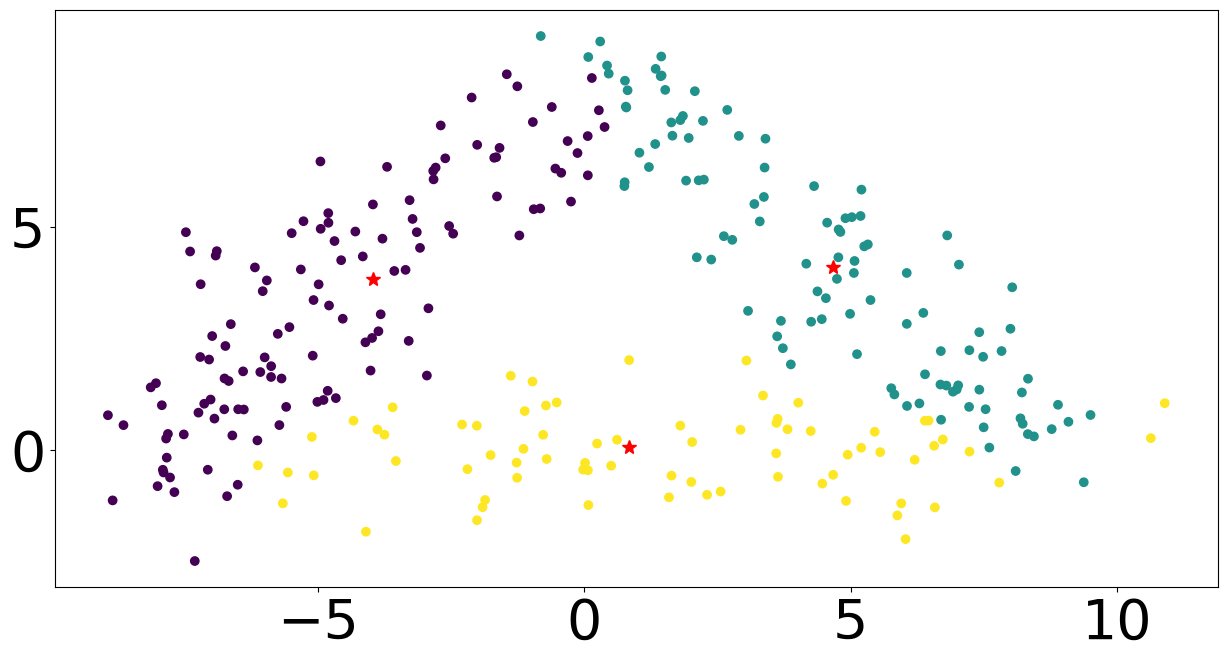

In [223]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.argmax(lrs,axis=1))
plt.plot(ms[:,0],ms[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(ms[k,:], invWs[k,:,:]/nus[k])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [224]:
# account for label permutation
mf_pred_wf=np.argmax(lrs,axis=1)
mf_pred_wf=permute_labels(mf_pred_wf,0,1,K)


confusion_matrix(wf_true,mf_pred_wf,K)

array([[84.,  5.,  5.],
       [ 7., 97.,  2.],
       [16., 18., 66.]])

### Concrete

In [177]:
####################
####################
#    load data     #
####################
####################
path='sockeye/waveform/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

concrete_wf_losses=np.zeros((len(losses_files),10001))
concrete_wf_flows=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    concrete_wf_losses[i]=aux.pkl_load(path+losses_files[i])
    concrete_wf_flows[i]=aux.pkl_load(path+flows_files[i])
# end for

# got from cache and output text files
concrete_wf_cput = np.array([4519.023812302039,4992.13403178798,3862.350781198009,
                            4505.757341608056,4871.528694076929,4883.2353827030165,
                            9044.814667066094,5680.082381324028,6533.77610979008])

Text(0, 0.5, 'Loss')

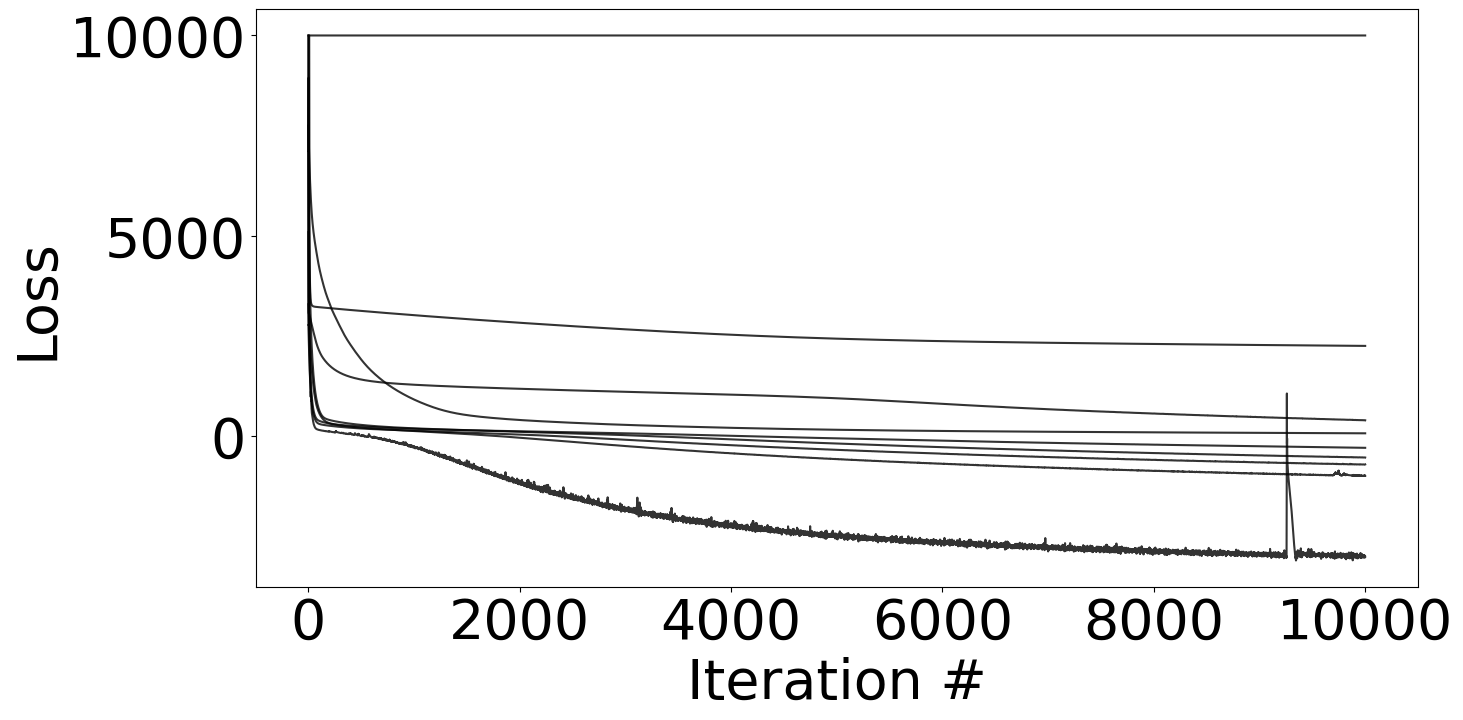

In [178]:
# loss traceplot
threshold=10000
plt_losses=np.copy(concrete_wf_losses)
plt_losses[plt_losses>threshold]=threshold
for i in range(len(losses_files)): plt.plot(np.arange(10001),plt_losses[i,:],c='black',alpha=0.8)
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [179]:
torch.manual_seed(1)
N,K,D=xs.shape[1],mus.shape[1],mus.shape[2]
idx=np.diag_indices(D)
for i in range(1):#range(len(flows_files)):
    tmp_sample=concrete_wf_flows[i].sample(1000)
    xd_wf,ws_wf,mus_wf,Sigmas_wf=concrete_gmm_unpack(tmp_sample,N,K,D)
    ws_wf,mus_wf,Sigmas_wf=ws_wf.detach().numpy(),mus_wf.detach().numpy(),Sigmas_wf.detach().numpy()
    Sigmas_wf[:,idx[0],idx[1],:]+=1e-1
    ws_wf-=aux.LogSumExp(ws_wf)
    ws_wf=np.exp(ws_wf)

/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/torch/distributions/wishart.py:253: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [180]:
gmm_lposterior(np.argmax(xd_wf,axis=1),ws_wf,mus_wf,Sigmas_wf,wf_dat,mu0,sigma0)

ValueError: The input vector 'x' must lie within the normal simplex. but np.sum(x, 0) = [1.0000001  0.99999994 1.         1.         1.         1.
 0.99999994 0.99999994 1.         0.99999994 0.9999999  1.0000001
 1.0000001  0.99999994 0.99999994 1.0000002  1.         0.9999999
 1.         1.         1.         1.         0.9999999  0.9999999
 1.         1.         1.         1.         0.9999999  1.
 0.9999999  0.99999994 1.         1.         1.         1.
 1.         1.         0.99999994 1.         0.99999994 0.9999999
 1.         1.0000001  1.         1.         1.         1.
 0.99999994 1.0000001  1.         1.0000002  1.         1.
 1.         0.9999999  1.0000001  1.         1.         0.9999999
 1.         1.0000001  0.9999999  1.         1.0000001  0.99999994
 1.         1.         1.0000001  1.         1.         1.
 0.99999994 1.         1.         0.9999999  1.0000001  1.
 0.99999994 1.         1.         0.9999999  1.         1.
 1.         0.9999999  1.         1.         1.         0.99999994
 1.         1.0000001  0.9999999  1.0000001  0.99999994 0.99999994
 1.         1.         1.         1.         1.         0.99999994
 1.         1.         0.99999994 1.         1.         1.
 1.0000001  1.         1.         1.0000001  0.9999999  1.
 0.9999999  1.0000001  1.0000001  1.0000001  1.         1.
 0.9999999  1.         0.99999994 0.99999994 1.         1.
 1.         1.         1.         1.         1.0000001  0.9999999
 1.         1.         1.0000001  1.0000001  1.         0.9999999
 1.         1.         1.         0.9999999  1.         1.
 0.9999999  1.0000001  1.         1.0000001  1.         0.99999994
 0.9999998  1.0000001  0.99999994 1.         1.0000001  1.
 0.99999994 1.         1.         1.         1.         0.9999999
 1.         1.         0.99999994 0.9999999  1.         1.
 1.         0.99999994 0.9999999  1.         0.9999999  1.
 1.         1.         1.         1.         0.9999999  1.
 1.         1.         1.         0.9999999  0.99999994 1.0000001
 1.         1.         1.         1.         0.99999994 1.
 0.9999999  1.         1.         0.99999994 1.         1.
 1.         1.         0.9999999  1.         1.         1.0000001
 1.0000001  0.9999999  1.         1.         1.         0.9999999
 1.         1.         0.99999994 1.         1.         0.9999999
 1.         0.9999999  1.         1.0000001  1.         1.
 1.         1.         1.         1.         1.         1.
 0.9999999  1.0000001  1.         1.         1.         0.99999994
 1.         1.         1.         1.         0.9999999  1.
 1.         1.0000001  1.         1.0000001  1.0000001  1.
 1.         1.         1.         1.         0.9999999  1.
 1.         1.         1.0000001  1.         0.9999999  1.
 1.0000001  1.0000001  1.0000001  1.         1.         1.
 1.         1.         1.         1.         1.         1.0000001
 1.         1.         1.         1.         1.         1.0000001
 1.0000001  1.         1.         0.99999994 1.         1.0000001
 0.9999999  1.         0.9999999  1.0000001  1.         1.
 1.         0.99999994 0.9999999  1.         1.         1.
 1.0000001  1.         1.         1.         0.9999999  1.
 1.         1.0000001  1.         1.         0.99999994 1.
 1.0000001  1.         1.         1.         1.         1.
 1.         1.         1.         1.0000001  1.         1.
 1.         1.         1.         1.         1.0000001  0.99999994
 1.0000001  0.99999994 0.99999994 1.         1.         1.
 0.9999999  1.         1.         0.99999994 0.99999994 1.0000001
 1.         1.         1.0000001  1.         1.         1.
 1.         0.99999994 1.         0.9999999  1.0000001  1.
 1.         1.         1.         1.         1.         1.0000001
 1.         0.99999994 1.0000001  0.9999999  0.99999994 0.99999994
 1.         1.         1.0000001  1.         1.         1.
 0.99999994 1.0000001  1.0000001  1.         1.         1.
 1.         0.99999994 1.         1.         1.         1.
 1.         1.         1.         1.0000001  0.9999999  1.
 1.         1.         1.         1.         1.         0.9999999
 1.         1.         1.         1.         1.0000001  0.99999994
 0.9999999  1.         1.         0.99999994 1.         1.
 1.         0.9999999  0.99999994 1.         1.         1.
 0.9999999  0.99999994 0.99999994 0.99999994 1.0000001  1.
 1.         1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.         1.         1.
 0.99999994 0.99999994 1.         1.         1.         1.
 1.0000001  0.9999999  1.0000002  0.9999999  1.         0.9999999
 1.         1.         1.         0.99999994 0.99999994 1.
 0.99999994 0.99999994 1.0000001  1.         1.         0.99999994
 0.9999999  0.99999994 1.         1.         1.         1.
 0.9999999  0.99999994 1.         1.         1.         1.
 1.         0.9999999  1.         1.         1.         1.
 1.0000001  1.         0.99999994 0.9999999  1.         0.99999994
 1.         1.         1.         1.         1.         1.
 1.         1.0000001  1.0000001  1.         1.         1.
 1.         1.         0.99999994 0.9999999  1.         1.
 0.99999994 0.99999994 1.         0.9999999  1.0000002  1.
 1.         0.9999999  1.         1.         0.9999999  0.99999994
 1.0000001  1.         1.         0.9999999  1.         1.
 1.         1.         1.         1.         1.         1.
 0.9999999  1.         1.0000001  0.9999999  0.9999999  1.
 1.0000001  1.         1.         1.         1.         0.99999994
 1.0000001  1.0000001  0.99999994 0.99999994 1.         1.
 1.         1.         1.         1.         1.         1.
 0.9999999  1.         1.         1.         1.         1.
 1.0000001  0.9999999  1.         1.         1.         0.9999999
 1.         1.         1.         0.99999994 1.         1.
 1.         1.         0.9999999  0.99999994 0.99999994 0.9999999
 1.0000001  1.         1.         1.         1.         1.
 1.         1.0000001  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.9999999  1.         1.0000001  1.
 0.9999999  1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.9999999  0.9999999
 0.99999994 1.         0.99999994 1.         0.9999999  1.
 1.         0.99999994 0.99999994 1.         0.99999994 1.
 1.         1.         1.         0.99999994 1.         0.99999994
 1.0000001  1.0000001  0.99999994 1.         1.         1.
 1.0000001  1.         1.         1.         1.         1.
 1.         0.99999994 1.         1.0000001  1.         0.9999999
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         0.9999999  1.         1.         1.
 1.         1.         0.9999999  0.99999994 0.9999999  1.
 1.0000001  0.9999999  1.         1.         1.         0.9999999
 1.         1.         0.9999999  1.0000001  1.         1.
 0.99999994 0.99999994 0.9999999  1.         1.         1.0000001
 1.0000001  1.0000001  1.         0.99999994 1.         1.0000001
 1.         1.         1.         1.         1.         1.
 1.         0.9999999  0.9999999  0.99999994 1.         1.
 0.99999994 1.         0.99999994 1.         0.9999999  1.
 1.0000001  0.9999999  0.9999999  1.0000001  1.         1.
 1.         1.         1.         0.99999994 1.         1.
 1.         1.         1.         0.9999999  1.         1.
 1.         1.0000001  1.         1.0000001  1.         1.0000001
 0.9999999  1.         0.99999994 1.         0.99999994 1.
 1.         1.         0.99999994 1.         1.         0.9999999
 1.         0.99999994 1.         0.99999994 0.9999999  1.
 1.         0.9999999  0.99999994 1.0000001  0.99999994 0.9999999
 1.         1.0000001  1.         1.         0.99999994 1.
 1.0000001  1.         1.         0.9999999  0.9999999  1.
 1.0000001  0.9999999  0.9999999  0.99999994 0.9999999  1.
 0.99999994 1.0000001  1.         1.         1.         1.
 0.9999999  1.0000001  1.         1.         1.         1.0000001
 1.0000001  1.         1.0000001  1.0000001  1.         1.
 1.         0.99999994 1.         0.99999994 0.99999994 1.
 0.99999994 1.         1.         1.         0.99999994 1.0000001
 0.99999994 0.9999999  0.99999994 1.0000001  1.         1.
 1.         1.         1.0000001  0.9999999  0.9999999  1.
 1.         1.         1.0000001  1.         0.99999994 1.
 1.         1.0000001  0.99999994 1.         0.99999994 0.9999999
 1.         0.9999999  1.         1.         1.         1.
 1.         1.0000001  0.9999999  1.         1.         1.0000001
 1.0000001  1.0000001  1.         1.         1.         0.99999994
 0.9999999  1.         1.         1.0000001  0.9999999  1.
 1.         1.         0.9999999  1.         1.         0.99999994
 1.         1.         0.99999994 1.         1.         0.9999999
 1.         1.         0.9999999  1.0000002  1.         0.99999994
 1.         0.99999994 1.         0.9999999  1.         1.
 0.9999999  0.99999994 1.0000001  1.         1.         1.
 0.99999994 1.         1.         0.9999999  0.99999994 1.
 1.         1.         1.         1.         0.9999999  1.
 1.0000001  1.         1.         1.         1.0000001  0.9999999
 0.99999994 1.         0.9999999  1.         1.         0.99999994
 1.         1.         1.0000001  1.         0.9999999  1.
 0.9999999  1.0000001  1.0000001  1.         0.99999994 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.0000001  1.         0.9999999  1.0000001
 1.         0.99999994 1.         1.         1.0000001  1.
 1.         1.         1.         1.         1.0000001  1.
 0.9999999  0.99999994 0.9999999  1.         1.         1.0000001
 1.         1.0000001  0.99999994 1.         1.         0.99999994
 1.         1.0000001  1.0000001  0.9999999  1.         1.0000001
 1.0000001  1.         1.         1.         1.0000001  1.
 1.0000001  1.         0.99999994 1.         1.0000001  1.
 1.         1.         0.9999999  1.         0.9999999  1.
 1.         1.         1.         1.         1.         1.
 1.         0.99999994 1.0000001  0.9999999  1.         1.
 0.99999994 1.         0.9999999  1.         1.         1.0000001
 0.9999999  1.0000001  1.0000001  1.         0.9999999  1.
 0.99999994 1.         0.9999999  1.0000001 ].

In [61]:
# retrieve best flow
i_star=np.argmin(losses[:,-1])
best_flow=flows[i_star]
print('Optimal flow: '+str(i_star))

Optimal flow: 1


In [63]:
# generate sample from optimal flow
#torch.manual_seed(1)
flow_sample=best_flow.sample(1000)

In [99]:
# loss 122 is smallest
# corresponds to: temp: 5, depth: 64, width: 50, lr: 1e-03
# here we train it manually
N,K,D=xs.shape[1],mus.shape[1],mus.shape[2]
tau0=0.1

temp = 5.
depth = 64
width = 50

lr = 1e-3
max_iters=10001

In [23]:
# sample generation
xs_concrete=torch.from_numpy(xs)
ws_concrete=torch.from_numpy(ws)
mus_concrete=torch.from_numpy(mus)
sigmas_concrete=torch.from_numpy(sigmas)

conc_sample=gmm_concrete_sample(xs_concrete,ws_concrete,mus_concrete,sigmas_concrete,temp)

In [24]:
RUN=False
if RUN:
    tmp_flow_waveform,tmp_loss_waveform=trainGMMRealNVP(
        temp=temp,depth=depth,N=N,K=K,D=D,tau0=tau0,sample=conc_sample,width=width,max_iters=max_iters,lr=lr,seed=2023,verbose=True
    )
# end if

iter 0: loss = 7110.931
iter 1000: loss = -246.430
iter 2000: loss = -1137.064
iter 3000: loss = -1863.825
iter 4000: loss = -2132.695
iter 5000: loss = -2471.192
iter 6000: loss = -2644.854
iter 7000: loss = -2804.740
iter 8000: loss = -2938.585
iter 9000: loss = -3014.458
iter 10000: loss = -3042.336


Text(0, 0.5, 'Loss')

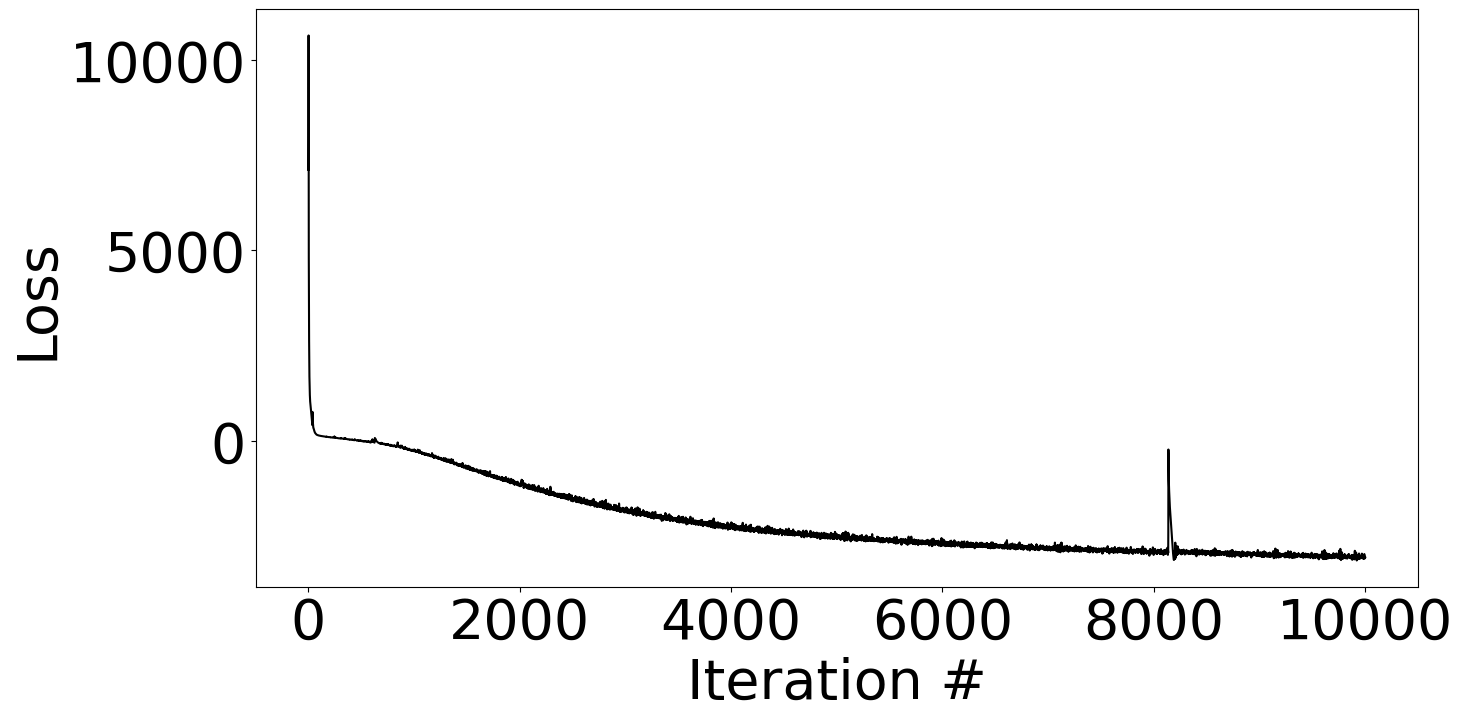

In [73]:
plt.plot(np.arange(10001),tmp_loss_waveform,c='black')
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [74]:
# generate sample from optimal flow
torch.manual_seed(1)
flow_sample_waveform=tmp_flow_waveform.sample(10000)

In [100]:
xd_wf,ws_wf,mus_wf,Sigmas_wf=concrete_gmm_unpack(flow_sample_waveform,N,K,D)
ws_wf,mus_wf,Sigmas_wf=ws_wf.detach().numpy(),mus_wf.detach().numpy(),Sigmas_wf.detach().numpy()

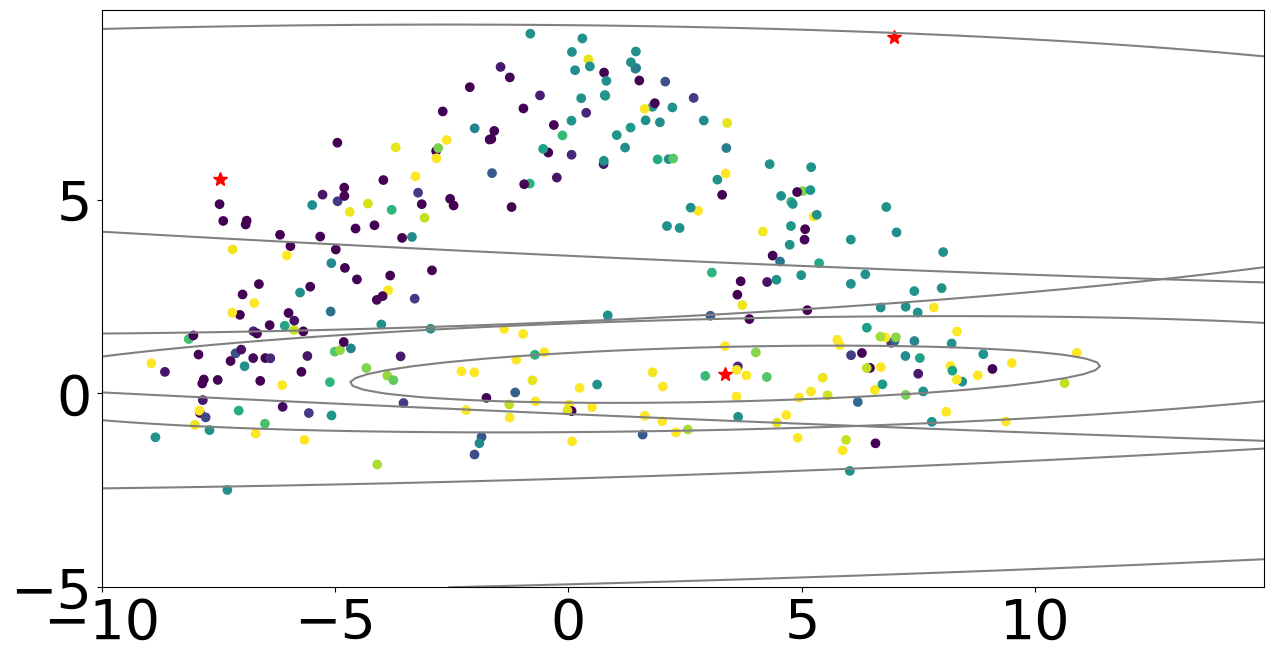

In [122]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.mean(np.argmax(np.exp(xd_wf),axis=1),axis=1))
plt.plot(np.mean(mus_wf,axis=2)[:,0],np.mean(mus_wf,axis=2)[:,1],'*r',ms=10)


xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus_wf,axis=2)[k,:], np.mean(Sigmas_wf,axis=3)[k,:,:])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=2,colors='grey')

In [225]:
# mad mix results
aux.pkl_save(madmix_elbos,'../summary/results/madmix_elbos_gmm')
aux.pkl_save(madmix_cput,'../summary/results/madmix_cput_gmm')

# gibbs results
aux.pkl_save(gibbs_cput,'../summary/results/gibbs_cput_gmm')

# mean field results
aux.pkl_save(meanfield_elbos,'../summary/results/meanfield_elbos_gmm')
aux.pkl_save(meanfield_cput,'../summary/results/meanfield_cput_gmm')

# concrete results
#concrete_elbos=np.vstack((elbos_onedim,elbos_twodim,elbos_mixture))
#concrete_cpu_times=np.vstack((concrete_pg_cput,cpu_times_twodim))
#aux.pkl_save(concrete_elbos,'../summary/results/concrete_elbos_toydiscrete')
aux.pkl_save(concrete_pg_cput,'../summary/results/concrete_cput_gmm_pg')
aux.pkl_save(concrete_wf_cput,'../summary/results/concrete_cput_gmm_wf')